In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 188 kB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7165, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 7165 (delta 47), reused 157 (delta 37), pack-reused 6988
Receiving objects: 100% (7165/7165), 13.86 MiB | 45.33 MiB/s, done.
Resolving deltas: 100% (5214/5214), done.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-24 01:53:00--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  8.40MB/s    in 34s     

2022-05-24 01:53:34 (9.30 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='DiceLoss'

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-24 01:53:37,382 - mmseg - INFO - Loaded 537 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-24 01:53:48,498 - mmseg - INFO - Loaded 113 images
2022-05-24 01:53:48,502 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-24 01:53:48,943 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 449s, ETA:     0s

2022-05-24 02:07:45,769 - mmseg - INFO - per class results:
2022-05-24 02:07:45,772 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.65 | 94.44 |
|  building  | 75.07 |  83.8 |
+------------+-------+-------+
2022-05-24 02:07:45,775 - mmseg - INFO - Summary:
2022-05-24 02:07:45,776 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 91.0 | 81.36 | 89.12 |
+------+-------+-------+
2022-05-24 02:07:45,779 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9100, mIoU: 0.8136, mAcc: 0.8912, IoU.background: 0.8765, IoU.building: 0.7507, Acc.background: 0.9444, Acc.building: 0.8380
2022-05-24 02:08:19,716 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:09:20, time: 4.834, data_time: 4.521, memory: 3323, decode.loss_ce: 0.2786, decode.loss_dice: 0.1048, decode.loss_lovasz: 0.2519, decode.acc_seg: 88.6770, loss: 0.6354
2022-05-24 02:08:51,593 - mmseg - INFO - Iter [1200/2000

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 02:20:25,304 - mmseg - INFO - per class results:
2022-05-24 02:20:25,306 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.32 | 94.13 |
|  building  | 79.04 | 88.74 |
+------------+-------+-------+
2022-05-24 02:20:25,308 - mmseg - INFO - Summary:
2022-05-24 02:20:25,309 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.39 | 84.18 | 91.44 |
+-------+-------+-------+
2022-05-24 02:20:25,314 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9239, mIoU: 0.8418, mAcc: 0.9144, IoU.background: 0.8932, IoU.building: 0.7904, Acc.background: 0.9413, Acc.building: 0.8874
2022-05-24 02:20:57,220 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 3:51:18, time: 4.613, data_time: 4.299, memory: 3323, decode.loss_ce: 0.2460, decode.loss_dice: 0.0909, decode.loss_lovasz: 0.2323, decode.acc_seg: 90.0791, loss: 0.5692
2022-05-24 02:21:31,017 - mmseg - INFO - Iter [2200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 02:33:03,116 - mmseg - INFO - per class results:
2022-05-24 02:33:03,118 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.42 | 93.08 |
|  building  | 79.88 | 91.43 |
+------------+-------+-------+
2022-05-24 02:33:03,120 - mmseg - INFO - Summary:
2022-05-24 02:33:03,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.55 | 84.65 | 92.26 |
+-------+-------+-------+
2022-05-24 02:33:03,124 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9255, mIoU: 0.8465, mAcc: 0.9226, IoU.background: 0.8942, IoU.building: 0.7988, Acc.background: 0.9308, Acc.building: 0.9143
2022-05-24 02:33:35,068 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:36:47, time: 4.615, data_time: 4.301, memory: 3323, decode.loss_ce: 0.2090, decode.loss_dice: 0.0760, decode.loss_lovasz: 0.1995, decode.acc_seg: 91.6933, loss: 0.4845
2022-05-24 02:34:07,024 - mmseg - INFO - Iter [3200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 02:45:42,994 - mmseg - INFO - per class results:
2022-05-24 02:45:42,996 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.15 | 95.43 |
|  building  |  80.1 | 87.74 |
+------------+-------+-------+
2022-05-24 02:45:42,998 - mmseg - INFO - Summary:
2022-05-24 02:45:43,002 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.95 | 85.12 | 91.59 |
+-------+-------+-------+
2022-05-24 02:45:43,004 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9295, mIoU: 0.8512, mAcc: 0.9159, IoU.background: 0.9015, IoU.building: 0.8010, Acc.background: 0.9543, Acc.building: 0.8774
2022-05-24 02:46:14,924 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:23:19, time: 4.614, data_time: 4.300, memory: 3323, decode.loss_ce: 0.1871, decode.loss_dice: 0.0773, decode.loss_lovasz: 0.1920, decode.acc_seg: 92.5221, loss: 0.4564
2022-05-24 02:46:46,840 - mmseg - INFO - Iter [4200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 02:58:19,582 - mmseg - INFO - per class results:
2022-05-24 02:58:19,585 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.61 | 95.41 |
|  building  | 81.15 | 88.94 |
+------------+-------+-------+
2022-05-24 02:58:19,587 - mmseg - INFO - Summary:
2022-05-24 02:58:19,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.32 | 85.88 | 92.17 |
+-------+-------+-------+
2022-05-24 02:58:19,591 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9332, mIoU: 0.8588, mAcc: 0.9217, IoU.background: 0.9061, IoU.building: 0.8115, Acc.background: 0.9541, Acc.building: 0.8894
2022-05-24 02:58:51,221 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:10:00, time: 4.609, data_time: 4.298, memory: 3323, decode.loss_ce: 0.2038, decode.loss_dice: 0.0776, decode.loss_lovasz: 0.1970, decode.acc_seg: 91.9247, loss: 0.4784
2022-05-24 02:59:22,807 - mmseg - INFO - Iter [5200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 03:10:54,404 - mmseg - INFO - per class results:
2022-05-24 03:10:54,405 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.5 | 94.66 |
|  building  | 81.31 |  90.4 |
+------------+-------+-------+
2022-05-24 03:10:54,408 - mmseg - INFO - Summary:
2022-05-24 03:10:54,410 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.28 | 85.91 | 92.53 |
+-------+-------+-------+
2022-05-24 03:10:54,412 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9328, mIoU: 0.8591, mAcc: 0.9253, IoU.background: 0.9050, IoU.building: 0.8131, Acc.background: 0.9466, Acc.building: 0.9040
2022-05-24 03:11:25,816 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 2:56:51, time: 4.607, data_time: 4.298, memory: 3323, decode.loss_ce: 0.1821, decode.loss_dice: 0.0660, decode.loss_lovasz: 0.1768, decode.acc_seg: 92.6811, loss: 0.4249
2022-05-24 03:11:57,367 - mmseg - INFO - Iter [6200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 03:23:28,332 - mmseg - INFO - per class results:
2022-05-24 03:23:28,334 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.62 | 94.76 |
|  building  | 81.52 | 90.45 |
+------------+-------+-------+
2022-05-24 03:23:28,336 - mmseg - INFO - Summary:
2022-05-24 03:23:28,337 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.37 | 86.07 | 92.61 |
+-------+-------+-------+
2022-05-24 03:23:28,339 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9337, mIoU: 0.8607, mAcc: 0.9261, IoU.background: 0.9062, IoU.building: 0.8152, Acc.background: 0.9476, Acc.building: 0.9045
2022-05-24 03:23:59,855 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:43:50, time: 4.608, data_time: 4.298, memory: 3323, decode.loss_ce: 0.1705, decode.loss_dice: 0.0628, decode.loss_lovasz: 0.1698, decode.acc_seg: 93.0745, loss: 0.4030
2022-05-24 03:24:31,397 - mmseg - INFO - Iter [7200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 03:36:00,031 - mmseg - INFO - per class results:
2022-05-24 03:36:00,032 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.58 | 94.43 |
|  building  | 81.61 | 91.11 |
+------------+-------+-------+
2022-05-24 03:36:00,036 - mmseg - INFO - Summary:
2022-05-24 03:36:00,038 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.36 | 86.1 | 92.77 |
+-------+------+-------+
2022-05-24 03:36:00,040 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9336, mIoU: 0.8610, mAcc: 0.9277, IoU.background: 0.9058, IoU.building: 0.8161, Acc.background: 0.9443, Acc.building: 0.9111
2022-05-24 03:36:33,579 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:30:56, time: 4.629, data_time: 4.319, memory: 3323, decode.loss_ce: 0.1733, decode.loss_dice: 0.0689, decode.loss_lovasz: 0.1776, decode.acc_seg: 93.1505, loss: 0.4198
2022-05-24 03:37:05,109 - mmseg - INFO - Iter [8200/2000

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-24 03:48:36,238 - mmseg - INFO - per class results:
2022-05-24 03:48:36,239 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.68 | 93.92 |
|  building  |  82.1 | 92.53 |
+------------+-------+-------+
2022-05-24 03:48:36,242 - mmseg - INFO - Summary:
2022-05-24 03:48:36,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.47 | 86.39 | 93.23 |
+-------+-------+-------+
2022-05-24 03:48:36,248 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9347, mIoU: 0.8639, mAcc: 0.9323, IoU.background: 0.9068, IoU.building: 0.8210, Acc.background: 0.9392, Acc.building: 0.9253
2022-05-24 03:49:07,771 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:18:07, time: 4.632, data_time: 4.323, memory: 3323, decode.loss_ce: 0.1785, decode.loss_dice: 0.0640, decode.loss_lovasz: 0.1723, decode.acc_seg: 92.7958, loss: 0.4148
2022-05-24 03:49:41,407 - mmseg - INFO - Iter [9200

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-24 04:01:11,292 - mmseg - INFO - per class results:
2022-05-24 04:01:11,294 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.88 |  94.5 |
|  building  | 82.21 | 91.66 |
+------------+-------+-------+
2022-05-24 04:01:11,295 - mmseg - INFO - Summary:
2022-05-24 04:01:11,300 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.58 | 86.54 | 93.08 |
+-------+-------+-------+
2022-05-24 04:01:11,302 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9358, mIoU: 0.8654, mAcc: 0.9308, IoU.background: 0.9088, IoU.building: 0.8221, Acc.background: 0.9450, Acc.building: 0.9166
2022-05-24 04:01:42,777 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:05:21, time: 4.618, data_time: 4.309, memory: 3323, decode.loss_ce: 0.1689, decode.loss_dice: 0.0616, decode.loss_lovasz: 0.1684, decode.acc_seg: 93.1542, loss: 0.3989
2022-05-24 04:02:14,242 - mmseg - INFO - Iter [102

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 04:13:46,932 - mmseg - INFO - per class results:
2022-05-24 04:13:46,933 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.97 | 94.73 |
|  building  | 82.29 | 91.36 |
+------------+-------+-------+
2022-05-24 04:13:46,935 - mmseg - INFO - Summary:
2022-05-24 04:13:46,936 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.64 | 86.63 | 93.04 |
+-------+-------+-------+
2022-05-24 04:13:46,939 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9364, mIoU: 0.8663, mAcc: 0.9304, IoU.background: 0.9097, IoU.building: 0.8229, Acc.background: 0.9473, Acc.building: 0.9136
2022-05-24 04:14:18,461 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:52:38, time: 4.610, data_time: 4.300, memory: 3323, decode.loss_ce: 0.1624, decode.loss_dice: 0.0608, decode.loss_lovasz: 0.1673, decode.acc_seg: 93.3378, loss: 0.3904
2022-05-24 04:14:50,037 - mmseg - INFO - Iter [112

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-24 04:26:21,719 - mmseg - INFO - per class results:
2022-05-24 04:26:21,721 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.87 | 94.57 |
|  building  | 82.15 | 91.47 |
+------------+-------+-------+
2022-05-24 04:26:21,723 - mmseg - INFO - Summary:
2022-05-24 04:26:21,725 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.57 | 86.51 | 93.02 |
+-------+-------+-------+
2022-05-24 04:26:21,727 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9357, mIoU: 0.8651, mAcc: 0.9302, IoU.background: 0.9087, IoU.building: 0.8215, Acc.background: 0.9457, Acc.building: 0.9147
2022-05-24 04:26:53,072 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:39:56, time: 4.616, data_time: 4.308, memory: 3323, decode.loss_ce: 0.1617, decode.loss_dice: 0.0599, decode.loss_lovasz: 0.1640, decode.acc_seg: 93.4882, loss: 0.3856
2022-05-24 04:27:24,596 - mmseg - INFO - Iter [122

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-24 04:38:57,536 - mmseg - INFO - per class results:
2022-05-24 04:38:57,538 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.47 | 95.24 |
|  building  | 83.12 | 91.39 |
+------------+-------+-------+
2022-05-24 04:38:57,542 - mmseg - INFO - Summary:
2022-05-24 04:38:57,543 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.99 | 87.29 | 93.31 |
+-------+-------+-------+
2022-05-24 04:38:57,546 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9399, mIoU: 0.8729, mAcc: 0.9331, IoU.background: 0.9147, IoU.building: 0.8312, Acc.background: 0.9524, Acc.building: 0.9139
2022-05-24 04:39:29,019 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:27:15, time: 4.617, data_time: 4.308, memory: 3323, decode.loss_ce: 0.1512, decode.loss_dice: 0.0546, decode.loss_lovasz: 0.1509, decode.acc_seg: 93.9282, loss: 0.3566
2022-05-24 04:40:00,484 - mmseg - INFO - Iter [132

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-24 04:51:34,452 - mmseg - INFO - per class results:
2022-05-24 04:51:34,453 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.29 | 95.81 |
|  building  | 82.42 | 89.65 |
+------------+-------+-------+
2022-05-24 04:51:34,458 - mmseg - INFO - Summary:
2022-05-24 04:51:34,459 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.81 | 86.86 | 92.73 |
+-------+-------+-------+
2022-05-24 04:51:34,462 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9381, mIoU: 0.8686, mAcc: 0.9273, IoU.background: 0.9129, IoU.building: 0.8242, Acc.background: 0.9581, Acc.building: 0.8965
2022-05-24 04:52:05,971 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:14:35, time: 4.617, data_time: 4.307, memory: 3323, decode.loss_ce: 0.1627, decode.loss_dice: 0.0585, decode.loss_lovasz: 0.1623, decode.acc_seg: 93.4671, loss: 0.3835
2022-05-24 04:52:37,521 - mmseg - INFO - Iter [142

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-24 05:04:06,295 - mmseg - INFO - per class results:
2022-05-24 05:04:06,297 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.32 |  95.3 |
|  building  | 82.77 | 90.91 |
+------------+-------+-------+
2022-05-24 05:04:06,302 - mmseg - INFO - Summary:
2022-05-24 05:04:06,304 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.88 | 87.04 | 93.1 |
+-------+-------+------+
2022-05-24 05:04:06,305 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9388, mIoU: 0.8704, mAcc: 0.9310, IoU.background: 0.9132, IoU.building: 0.8277, Acc.background: 0.9530, Acc.building: 0.9091
2022-05-24 05:04:39,805 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:01:55, time: 4.630, data_time: 4.321, memory: 3323, decode.loss_ce: 0.1372, decode.loss_dice: 0.0513, decode.loss_lovasz: 0.1417, decode.acc_seg: 94.4853, loss: 0.3302
2022-05-24 05:05:11,314 - mmseg - INFO - Iter [15200/20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-24 05:16:42,163 - mmseg - INFO - per class results:
2022-05-24 05:16:42,165 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.57 | 95.93 |
|  building  | 82.99 | 90.05 |
+------------+-------+-------+
2022-05-24 05:16:42,167 - mmseg - INFO - Summary:
2022-05-24 05:16:42,169 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.03 | 87.28 | 92.99 |
+-------+-------+-------+
2022-05-24 05:16:42,173 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9403, mIoU: 0.8728, mAcc: 0.9299, IoU.background: 0.9157, IoU.building: 0.8299, Acc.background: 0.9593, Acc.building: 0.9005
2022-05-24 05:17:13,687 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:49:16, time: 4.622, data_time: 4.313, memory: 3323, decode.loss_ce: 0.1492, decode.loss_dice: 0.0554, decode.loss_lovasz: 0.1529, decode.acc_seg: 93.9740, loss: 0.3575
2022-05-24 05:17:47,225 - mmseg - INFO - Iter [162

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-24 05:29:16,801 - mmseg - INFO - per class results:
2022-05-24 05:29:16,802 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.61 | 95.53 |
|  building  | 83.27 | 91.06 |
+------------+-------+-------+
2022-05-24 05:29:16,803 - mmseg - INFO - Summary:
2022-05-24 05:29:16,805 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.08 | 87.44 | 93.29 |
+-------+-------+-------+
2022-05-24 05:29:16,808 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9408, mIoU: 0.8744, mAcc: 0.9329, IoU.background: 0.9161, IoU.building: 0.8327, Acc.background: 0.9553, Acc.building: 0.9106
2022-05-24 05:29:48,186 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:36:37, time: 4.620, data_time: 4.312, memory: 3323, decode.loss_ce: 0.1580, decode.loss_dice: 0.0611, decode.loss_lovasz: 0.1492, decode.acc_seg: 94.0080, loss: 0.3683
2022-05-24 05:30:21,708 - mmseg - INFO - Iter [172

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-24 05:41:53,547 - mmseg - INFO - per class results:
2022-05-24 05:41:53,549 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.51 | 95.06 |
|  building  |  83.3 |  91.9 |
+------------+-------+-------+
2022-05-24 05:41:53,551 - mmseg - INFO - Summary:
2022-05-24 05:41:53,554 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.04 | 87.41 | 93.48 |
+-------+-------+-------+
2022-05-24 05:41:53,560 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9404, mIoU: 0.8741, mAcc: 0.9348, IoU.background: 0.9151, IoU.building: 0.8330, Acc.background: 0.9506, Acc.building: 0.9190
2022-05-24 05:42:25,048 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:23:59, time: 4.622, data_time: 4.312, memory: 3323, decode.loss_ce: 0.1418, decode.loss_dice: 0.0615, decode.loss_lovasz: 0.1503, decode.acc_seg: 94.1804, loss: 0.3536
2022-05-24 05:42:56,529 - mmseg - INFO - Iter [182

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-24 05:54:28,057 - mmseg - INFO - per class results:
2022-05-24 05:54:28,058 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.62 |  95.3 |
|  building  |  83.4 | 91.61 |
+------------+-------+-------+
2022-05-24 05:54:28,061 - mmseg - INFO - Summary:
2022-05-24 05:54:28,063 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 94.1 | 87.51 | 93.45 |
+------+-------+-------+
2022-05-24 05:54:28,065 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9410, mIoU: 0.8751, mAcc: 0.9345, IoU.background: 0.9162, IoU.building: 0.8340, Acc.background: 0.9530, Acc.building: 0.9161
2022-05-24 05:54:59,439 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:21, time: 4.620, data_time: 4.311, memory: 3323, decode.loss_ce: 0.1478, decode.loss_dice: 0.0536, decode.loss_lovasz: 0.1525, decode.acc_seg: 93.9526, loss: 0.3539
2022-05-24 05:55:30,934 - mmseg - INFO - Iter [19200/20

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-24 06:07:03,935 - mmseg - INFO - per class results:
2022-05-24 06:07:03,937 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.76 | 95.72 |
|  building  | 83.51 | 90.99 |
+------------+-------+-------+
2022-05-24 06:07:03,940 - mmseg - INFO - Summary:
2022-05-24 06:07:03,942 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 94.19 | 87.64 | 93.35 |
+-------+-------+-------+
2022-05-24 06:07:03,943 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9419, mIoU: 0.8764, mAcc: 0.9335, IoU.background: 0.9176, IoU.building: 0.8351, Acc.background: 0.9572, Acc.building: 0.9099


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


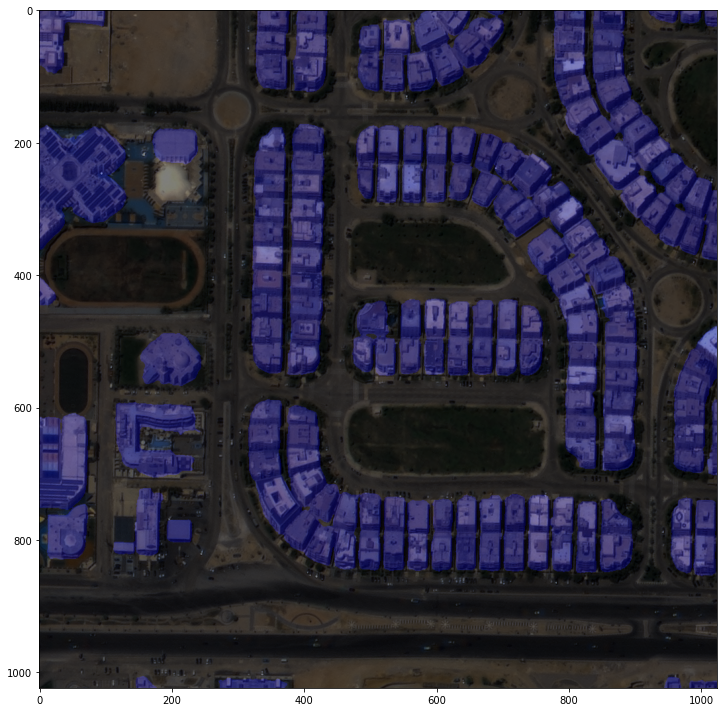

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


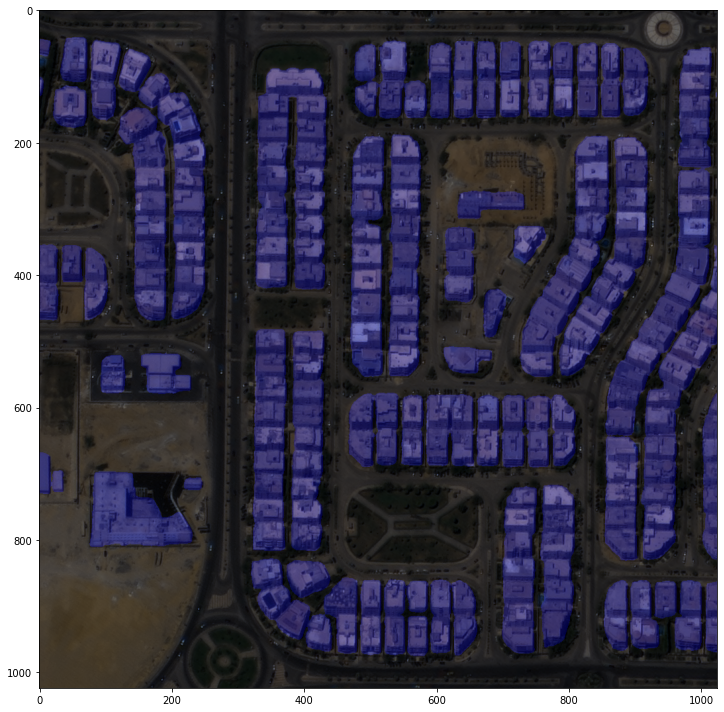

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


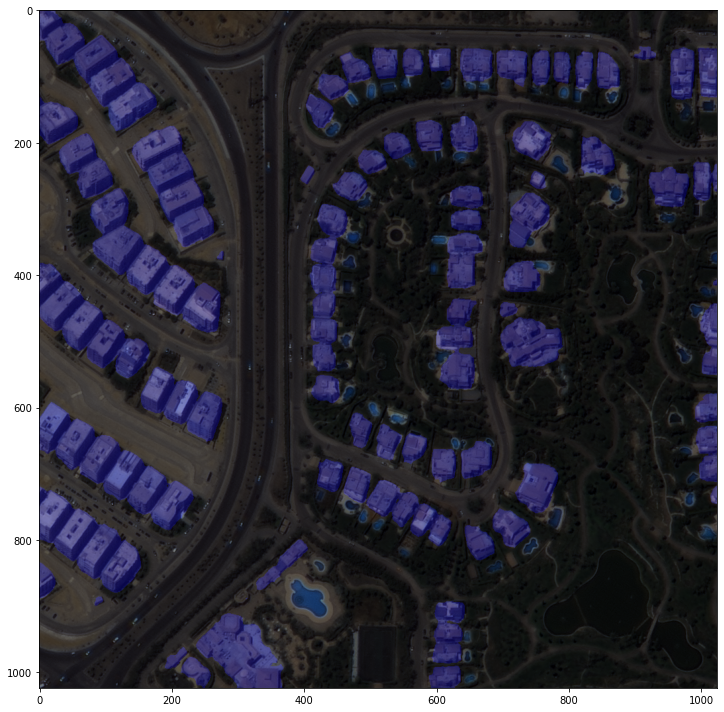

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


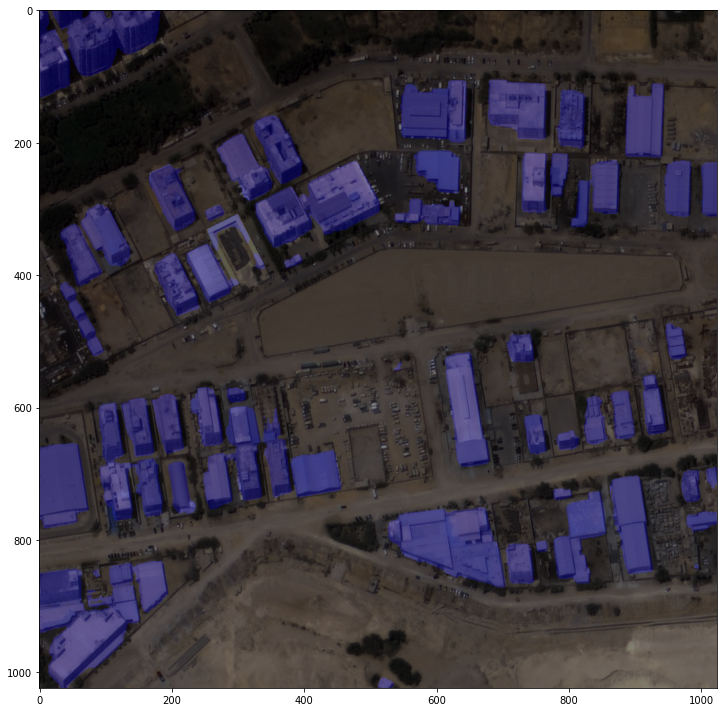

In [24]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/building/batch1_ce_focal_lovasz/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)